<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-10-09 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


# Formatting for PyUnfold use
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)
6. [Feature importance](#Feature-importance)

In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
from scipy.sparse import block_diag
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import json
from scipy.interpolate import UnivariateSpline

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [18]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

Define energy binning for this analysis

In [19]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [20]:
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012', log_energy_min=6.0, log_energy_max=8.3)

In [21]:
log_energy_sim_test = df_sim_test['lap_log_energy']
log_reco_energy_sim_test = df_sim_test['lap_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']

In [22]:
feature_list, feature_labels = comp.analysis.get_training_features()

In [23]:
pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

In [24]:
pipeline

Pipeline(steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

In [25]:
pipeline.fit(df_sim_train[feature_list], df_sim_train['target'])

Pipeline(steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

## Load fitted effective area

In [26]:
eff_area_path = os.path.join(comp.paths.comp_data_dir, 'unfolding',
                        'effective_area_fit.hdf')
df_eff_area = pd.read_hdf(eff_area_path)

In [27]:
df_eff_area

,eff_area_median_light,eff_area_err_low_light,eff_area_err_high_light,eff_area_median_heavy,eff_area_err_low_heavy,eff_area_err_high_heavy
0,52966.267881,765.914377,744.919495,42052.801029,700.566477,679.644276
1,64632.104085,757.666598,722.059688,58122.034321,800.515111,718.461170
2,71837.374695,596.731071,663.550246,67755.175834,611.798955,638.977151
3,75832.449250,566.814928,605.632145,72569.170303,605.032426,612.919042
4,77978.657308,628.223708,629.885211,74953.801796,608.163174,633.296330
5,79132.494826,603.828695,656.774114,76374.119398,600.852336,611.881654
6,79856.263442,569.969721,626.868608,77400.526441,547.223049,553.023432
7,80374.594533,542.399648,554.479989,78282.081621,476.732331,523.570269
8,80778.352903,509.739530,500.197491,79115.089885,456.303085,484.887576
9,81154.949005,504.600867,487.915977,79921.814283,462.808346,463.620873


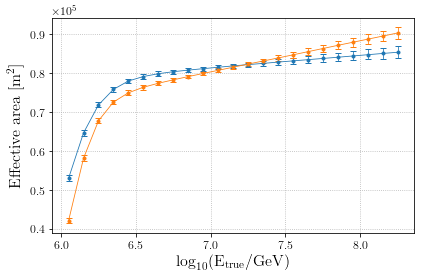

In [28]:
fig, ax = plt.subplots()
for composition in comp_list:
    ax.errorbar(energybins.log_energy_midpoints, df_eff_area['eff_area_median_{}'.format(composition)],
                yerr=[df_eff_area['eff_area_err_low_{}'.format(composition)],
                      df_eff_area['eff_area_err_high_{}'.format(composition)]], 
                color=color_dict[composition], label=composition, marker='.')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Effective area [m$^2$]')
ax.grid()
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))
plt.show()

In [29]:
norm = np.pi * 2600.0**2
# norm = np.max([df_eff_area['eff_area_median_{}'.format(composition)].sum() for composition in comp_list])
norm

21237166.338267002

In [30]:
efficiencies = np.empty(len(energybins.log_energy_midpoints)*2)
efficiencies_err = np.empty(len(energybins.log_energy_midpoints)*2)

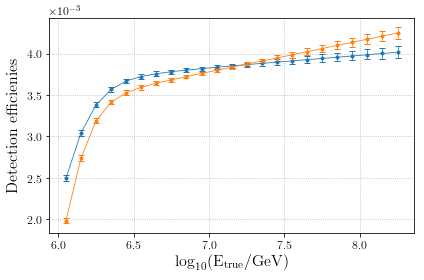

In [31]:
fig, ax = plt.subplots()
for composition in comp_list:
    eff_area_norm = df_eff_area['eff_area_median_{}'.format(composition)] / norm
    eff_area_err_low = df_eff_area['eff_area_err_low_{}'.format(composition)] / norm
    eff_area_err_high = df_eff_area['eff_area_err_high_{}'.format(composition)] / norm
    start_idx = 0 if composition == 'light' else 1
    efficiencies[start_idx::2] = eff_area_norm
    efficiencies_err[start_idx::2] = eff_area_err_low
    ax.errorbar(energybins.log_energy_midpoints, eff_area_norm,
                yerr=[eff_area_err_low, eff_area_err_high],
                color=color_dict[composition], label=composition, marker='.')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('Detection efficienies')
ax.grid()
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))
plt.show()

In [32]:
efficiencies

array([ 0.00249404,  0.00198015,  0.00304335,  0.00273681,  0.00338263,
        0.00319041,  0.00357074,  0.00341708,  0.0036718 ,  0.00352937,
        0.00372613,  0.00359625,  0.00376021,  0.00364458,  0.00378462,
        0.00368609,  0.00380363,  0.00372531,  0.00382136,  0.0037633 ,
        0.00383836,  0.00380116,  0.00385477,  0.00383903,  0.00387036,
        0.00387669,  0.00388499,  0.00391401,  0.00390081,  0.00395043,
        0.00391555,  0.00398859,  0.00393025,  0.0040269 ,  0.00394492,
        0.00406532,  0.00395968,  0.00410362,  0.00397502,  0.00414091,
        0.00399024,  0.0041784 ,  0.00400538,  0.00421562,  0.00402002,
        0.00425389])

In [33]:
df_data = comp.load_data(config='IC86.2012', log_energy_min=6.0, log_energy_max=8.3)

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:151: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:152: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_energy'] = np.log10(df['d4r_peak_energy'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:153: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_sigma'] = np.log10(df['d4r_peak_sigma'])


In [34]:
X_data = comp.dataframe_functions.dataframe_to_array(df_data, feature_list + ['lap_log_energy'])
log_energy_data = X_data[:,-1]
X_data = X_data[:,:-1]

In [35]:
log_energy_data.max()

8.2992900268980669

In [39]:
# is_finite_mask = np.isfinite(data.X)
# not_finite_mask = np.logical_not(is_finite_mask)
# finite_data_mask = np.logical_not(np.any(not_finite_mask, axis=1))
# data = data[finite_data_mask]

In [36]:
data_predictions = pipeline.predict(X_data)

In [37]:
# Get composition masks
data_labels = np.array([comp.dataframe_functions.label_to_comp(pred) for pred in data_predictions])
data_light_mask = data_labels == 'light'
data_heavy_mask = data_labels == 'heavy'

In [38]:
# Get number of identified comp in each energy bin
df_flux = {}
comp_list = ['light', 'heavy']
for composition in comp_list:
    comp_mask = data_labels == composition
    df_flux['counts_' + composition] = np.histogram(log_energy_data[comp_mask],
                                                    bins=energybins.log_energy_bins)[0]
    df_flux['counts_' + composition + '_err'] = np.sqrt(df_flux['counts_' + composition])

df_flux['counts_total'] = np.histogram(log_energy_data, bins=energybins.log_energy_bins)[0]
df_flux['counts_total_err'] = np.sqrt(df_flux['counts_total'])

In [39]:
energybins.log_energy_bins.shape

(24,)

In [40]:
# Get number of identified comp in each energy bin
unfolding_df = pd.DataFrame(df_flux)
comp_list = ['light', 'heavy']
for composition in comp_list:
    comp_mask = data_labels == composition
    unfolding_df['counts_' + composition] = np.histogram(log_energy_data[comp_mask],
                                                         bins=energybins.log_energy_bins)[0]
    unfolding_df['counts_' + composition + '_err'] = np.sqrt(df_flux['counts_' + composition])

unfolding_df['counts_total'] = np.histogram(log_energy_data, bins=energybins.log_energy_bins)[0]
unfolding_df['counts_total_err'] = np.sqrt(unfolding_df['counts_total'])

In [41]:
unfolding_df.index.rename('log_energy_bin_idx', inplace=True)

In [42]:
unfolding_df

,counts_heavy,counts_heavy_err,counts_light,counts_light_err,counts_total,counts_total_err
log_energy_bin_idx,,,,,,
0,665828,815.982843,1352390,1162.923041,2018218,1420.639997
1,533109,730.143137,1064113,1031.558530,1597222,1263.812486
2,447248,668.766028,742612,861.749384,1189860,1090.807041
3,332069,576.254284,521807,722.362098,853876,924.054111
4,225416,474.779949,368332,606.903617,593748,770.550453
5,143558,378.890485,258678,508.603972,402236,634.220782
6,98431,313.737151,165036,406.246231,263467,513.290366
7,69492,263.613353,99282,315.090463,168774,410.821129
8,40949,202.358593,64708,254.377672,105657,325.049227


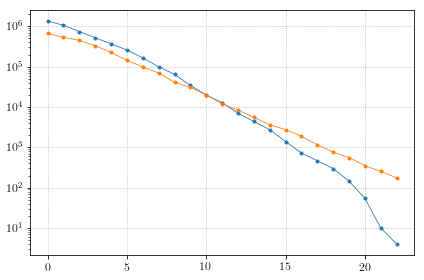

In [43]:
plt.plot(unfolding_df['counts_light'])
plt.plot(unfolding_df['counts_heavy'])
plt.yscale("log", nonposy='clip')
plt.grid()
plt.show()

## Spectrum
[ [back to top](#top) ]

### Number of events observed

In [44]:
# num_particles, num_particles_err = comp.analysis.get_num_particles(sim_train, data, pipeline, comp_list)

In [45]:
# unfolding_df['counts_light'] = num_particles['light']
# unfolding_df['counts_heavy'] = num_particles['heavy']
# unfolding_df['counts_err_light'] = num_particles_err['light']
# unfolding_df['counts_err_heavy'] = num_particles_err['heavy']

### Block diagonal response matrix and error

In [46]:
# pipeline.fit(sim_train.X, sim_train.y)
test_predictions = pipeline.predict(df_sim_test[feature_list])
true_comp = df_sim_test['target'].apply(comp.dataframe_functions.label_to_comp)
pred_comp = pd.Series([comp.dataframe_functions.label_to_comp(i) for i in test_predictions])

In [47]:
# response_list = []
# response_err_list = []
# sim_bin_idxs = np.digitize(log_energy_sim_test, energybins.log_energy_bins) - 1
# energy_bin_idx = np.unique(sim_bin_idxs)
# # energy_bin_idx = energy_bin_idx[1:]
# print(energy_bin_idx)
# # print(energybins.energy_midpoints.shape)
# for bin_idx in energy_bin_idx:
#     if (bin_idx == -1) or (bin_idx == energybins.energy_midpoints.shape[0]):
#         continue
#     sim_bin_mask = sim_bin_idxs == bin_idx
#     response_mat = confusion_matrix(true_comp[sim_bin_mask], pred_comp[sim_bin_mask],
#                                     labels=comp_list)
#     # Transpose response matrix to get MC comp on x-axis and reco comp on y-axis
#     response_mat = response_mat.T
#     # Get response matrix statistical error
#     response_mat_err = np.sqrt(response_mat)
#     response_err_list.append(response_mat_err)
#     response_list.append(response_mat)
# block_response = block_diag(response_list).toarray()
# # block_response = np.flipud(block_response)

# # Normalize along MC comp axis to go from counts to probabilities
# block_response = block_response / block_response.sum(axis=0)
# print('block_response = \n{}'.format(block_response))
# block_response_err = block_diag(response_err_list).toarray()
# # block_response_err = np.flipud(block_response_err)
# block_response_err = block_response_err / block_response_err.sum(axis=0)
# print('block_response_err = \n{}'.format(block_response_err))

In [48]:
# res_mat_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'block_response.txt')
# res_mat_err_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'block_response_err.txt')

# comp.check_output_dir(res_mat_outfile)
# comp.check_output_dir(res_mat_err_outfile)

# np.savetxt(res_mat_outfile, block_response)
# np.savetxt(res_mat_err_outfile, block_response_err)

In [49]:
range(-1, len(energybins.log_energy_midpoints)+2)

[-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [50]:
true_ebin_idxs = np.digitize(log_true_energy_sim_test, energybins.log_energy_bins) - 1
reco_ebin_idxs = np.digitize(log_reco_energy_sim_test, energybins.log_energy_bins) - 1
energy_bin_idx = np.unique(true_ebin_idxs)
print(range(-1, len(energybins.log_energy_midpoints)+1))

hstack_list = []
# for true_ebin_idx in energy_bin_idx:
for true_ebin_idx in range(-1, len(energybins.log_energy_midpoints)+1):
    if (true_ebin_idx == -1) or (true_ebin_idx == energybins.energy_midpoints.shape[0]):
        continue
    true_ebin_mask = true_ebin_idxs == true_ebin_idx
    
    vstack_list = []
#     for reco_ebin_idx in energy_bin_idx:
    for reco_ebin_idx in range(-1, len(energybins.log_energy_midpoints)+1):
        if (reco_ebin_idx == -1) or (reco_ebin_idx == energybins.energy_midpoints.shape[0]):
            continue
        reco_ebin_mask = reco_ebin_idxs == reco_ebin_idx
        
        combined_mask = true_ebin_mask & reco_ebin_mask
        if combined_mask.sum() == 0:
            response_mat = np.zeros((2, 2), dtype=int)
        else:
            response_mat = confusion_matrix(true_comp[true_ebin_mask & reco_ebin_mask],
                                            pred_comp[true_ebin_mask & reco_ebin_mask],
                                            labels=comp_list)
        # Transpose response matrix to get MC comp on x-axis and reco comp on y-axis
        response_mat = response_mat.T
        vstack_list.append(response_mat)
    hstack_list.append(np.vstack(vstack_list))
    
res = np.hstack(hstack_list)
res_err = np.sqrt(res)

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [51]:
res.shape

(46, 46)

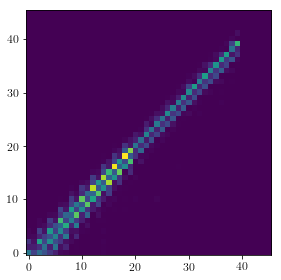

In [52]:
plt.imshow(res, origin='lower')

### Normalize response matrix column-wise (i.e. $P(E|C)$)

In [53]:
# res_normalized = res / res.sum(axis=0)
# # Error propagate the repsonse matrix error
# res_err_normalized = res_err / res.sum(axis=0)
# # res_err = res_err / res_err.sum(axis=0)

# res_col_sum_err = np.array([np.sqrt(np.sum(res_err[:, i]**2)) for i in range(res_err.shape[1])])
# res_normalized, res_normalized_err = comp.analysis.ratio_error(res, res_err,
#                                                                res.sum(axis=0), res_col_sum_err,
#                                                                nan_to_num=True)

res_col_sum = res.sum(axis=0)
res_col_sum_err = np.array([np.sqrt(np.nansum(res_err[:, i]**2)) for i in range(res_err.shape[1])])

normalizations, normalizations_err = comp.analysis.ratio_error(res_col_sum, res_col_sum_err,
                                                               efficiencies, efficiencies_err,
                                                               nan_to_num=True)

res_normalized, res_normalized_err = comp.analysis.ratio_error(res, res_err,
                                                               normalizations, normalizations_err,
                                                               nan_to_num=True)


/home/jbourbeau/cr-composition/comptools/analysis/data_functions.py:27: RuntimeWarning: invalid value encountered in true_divide
  ratio_err = np.abs(ratio) * np.sqrt((num_err / num)**2 + (den_err / den)**2)
/home/jbourbeau/cr-composition/comptools/analysis/data_functions.py:26: RuntimeWarning: invalid value encountered in true_divide
  ratio = num/den


In [54]:
res_normalized = np.nan_to_num(res_normalized)
res_normalized_err = np.nan_to_num(res_normalized_err)

In [55]:
np.testing.assert_allclose(res_normalized.sum(axis=0), efficiencies)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 13.0434782609%)
 x: array([ 0.002494,  0.00198 ,  0.003043,  0.002737,  0.003383,  0.00319 ,
        0.003571,  0.003417,  0.003672,  0.003529,  0.003726,  0.003596,
        0.00376 ,  0.003645,  0.003785,  0.003686,  0.003804,  0.003725,...
 y: array([ 0.002494,  0.00198 ,  0.003043,  0.002737,  0.003383,  0.00319 ,
        0.003571,  0.003417,  0.003672,  0.003529,  0.003726,  0.003596,
        0.00376 ,  0.003645,  0.003785,  0.003686,  0.003804,  0.003725,...

In [56]:
res_normalized.sum(axis=0), efficiencies

(array([ 0.00249404,  0.00198015,  0.00304335,  0.00273681,  0.00338263,
         0.00319041,  0.00357074,  0.00341708,  0.0036718 ,  0.00352937,
         0.00372613,  0.00359625,  0.00376021,  0.00364458,  0.00378462,
         0.00368609,  0.00380363,  0.00372531,  0.00382136,  0.0037633 ,
         0.00383836,  0.00380116,  0.00385477,  0.00383903,  0.00387036,
         0.00387669,  0.00388499,  0.00391401,  0.00390081,  0.00395043,
         0.00391555,  0.00398859,  0.00393025,  0.0040269 ,  0.00394492,
         0.00406532,  0.00395968,  0.00410362,  0.00397502,  0.00414091,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.00249404,  0.00198015,  0.00304335,  0.00273681,  0.00338263,
         0.00319041,  0.00357074,  0.00341708,  0.0036718 ,  0.00352937,
         0.00372613,  0.00359625,  0.00376021,  0.00364458,  0.00378462,
         0.00368609,  0.00380363,  0.00372531,  0.00382136,  0.0037633 ,
         0.00383836,  0.00380116,  0

In [57]:
res_normalized

array([[ 0.00150231,  0.00111008,  0.00078966, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00030439,  0.00048004,  0.00030549, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0005695 ,  0.00025502,  0.00125077, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [58]:
res_normalized_err

array([[  1.55270163e-04,   1.62265389e-04,   7.62770545e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.80772955e-05,   9.49250947e-05,   4.41630855e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  8.32869579e-05,   6.58507578e-05,   1.01917878e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

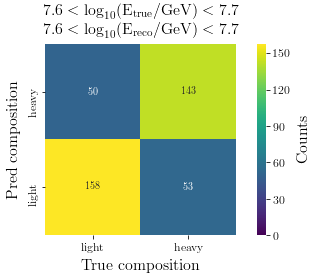

In [59]:
fig, ax = plt.subplots()
# h = np.flipud(block_response)
sns.heatmap(res[24:26, 24:26], annot=True, fmt='d', ax=ax, square=True,
           xticklabels=['light', 'heavy'], yticklabels=['light', 'heavy'],
           cbar_kws={'label': 'Counts'}, vmin=0, cmap='viridis')
ax.invert_yaxis()
plt.xlabel('True composition')
plt.ylabel('Pred composition')
plt.title('$\mathrm{7.6 < \log_{10}(E_{true}/GeV) < 7.7}$' + '\n$\mathrm{7.6 < \log_{10}(E_{reco}/GeV) < 7.7}$')
# res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix-single-energy-bin.png')
# comp.check_output_dir(res_mat_outfile)
# plt.savefig(res_mat_outfile)
plt.show()

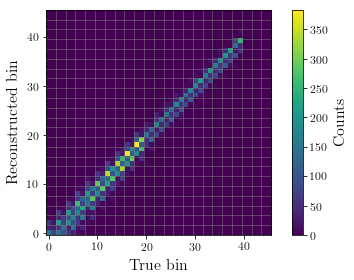

In [60]:
plt.imshow(res, origin='lower', cmap='viridis')

# ax = sns.heatmap(res, square=True, xticklabels=2, yticklabels=2, 
# ax = sns.heatmap(res, square=True, mask=res==0, xticklabels=2, yticklabels=2, 
#             cbar_kws={'label': 'Counts'})

ax.plot([0, res.shape[0]-1], [0, res.shape[1]-1], marker='None', ls=':', color='C1')

# ax.invert_yaxis()



for i in np.arange(0, res.shape[0], 2):
    plt.axvline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
# for i in np.arange(0, res.shape[0], 2):
#     plt.axvline(i+0.5, marker='None', ls=':', color='gray')
for i in np.arange(0, res.shape[0], 2):
    plt.axhline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
# for i in np.arange(0, res.shape[0], 2):
#     plt.axhline(i+0.5, marker='None', ls=':', color='gray')
    
plt.xlabel('True bin')
plt.ylabel('Reconstructed bin')
# plt.grid()

# plt.xticks(np.arange(0.5, res.shape[0], 2),
#            ['{}'.format(i+1) for i in range(res.shape[0])], 
#            rotation='vertical')
# plt.yticks(np.arange(0.5, res.shape[0], 2),
#            ['{}'.format(i+1) for i in range(res.shape[0])])

plt.colorbar(label='Counts')

res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-statistics.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

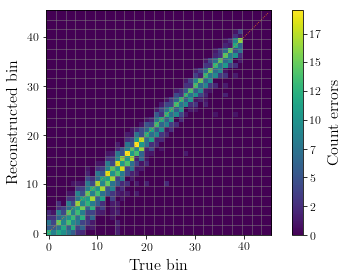

In [61]:
plt.imshow(np.sqrt(res), origin='lower', cmap='viridis')
plt.plot([0, res.shape[0]-1], [0, res.shape[1]-1], marker='None', ls=':', color='C1')

for i in np.arange(0, res.shape[0], 2):
    plt.axvline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
for i in np.arange(0, res.shape[0], 2):
    plt.axhline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
    
plt.xlabel('True bin')
plt.ylabel('Reconstructed bin')

plt.colorbar(label='Count errors', format='%d')

res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-statistics-err.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

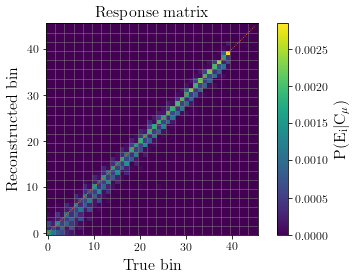

In [62]:
plt.imshow(res_normalized, origin='lower', cmap='viridis')
plt.plot([0, res.shape[0]-1], [0, res.shape[1]-1], marker='None', ls=':', color='C1')

for i in np.arange(0, res.shape[0], 2):
    plt.axvline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
for i in np.arange(0, res.shape[0], 2):
    plt.axhline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
    
plt.xlabel('True bin')
plt.ylabel('Reconstructed bin')
plt.title('Response matrix')

# plt.colorbar(label='A.U.')
plt.colorbar(label='$\mathrm{P(E_i|C_{\mu})}$')

res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

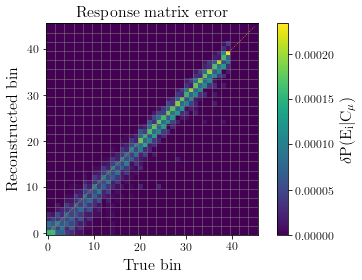

In [63]:
plt.imshow(res_normalized_err, origin='lower', cmap='viridis')
plt.plot([0, res.shape[0]-1], [0, res.shape[1]-1], marker='None', ls=':', color='C1')

for i in np.arange(0, res.shape[0], 2):
    plt.axvline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
for i in np.arange(0, res.shape[0], 2):
    plt.axhline(i-0.5, marker='None', ls='-', lw=0.5, color='gray')
    
plt.xlabel('True bin')
plt.ylabel('Reconstructed bin')
plt.title('Response matrix error')

plt.colorbar(label='$\mathrm{\delta P(E_i|C_{\mu})}$')

res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix-err.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

In [64]:
res_mat_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'response.txt')
res_mat_err_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'response_err.txt')

comp.check_output_dir(res_mat_outfile)
comp.check_output_dir(res_mat_err_outfile)

np.savetxt(res_mat_outfile, res_normalized)
np.savetxt(res_mat_err_outfile, res_normalized_err)

### Priors array

In [65]:
from icecube.weighting.weighting import from_simprod
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5

In [66]:
df_sim = comp.load_sim(config='IC86.2012', test_size=0, log_energy_min=6.0, log_energy_max=8.3)
df_sim.head()

,FractionContainment_Laputop_IceTop,FractionContainment_Laputop_InIce,FractionContainment_MCPrimary_IceTop,FractionContainment_MCPrimary_InIce,IceTopMaxSignal,IceTopMaxSignalInEdge,IceTopMaxSignalString,IceTopNeighbourMaxSignal,InIce_charge_1_60,MC_azimuth,...,log_dEdX,log_d4r_peak_energy,log_d4r_peak_sigma,target,two_component_groups,three_component_groups,four_component_groups,two_component_target,three_component_target,four_component_target
0,0.672916,0.596048,0.675481,0.649017,28.609421,0,29,12.178488,180.050000,5.673565,...,0.733548,1.251190,0.905364,0,light,light,PPlus,0,0,0
1,0.537961,0.760892,0.543832,0.771945,101.481819,0,38,68.172859,244.275001,5.673565,...,0.758869,1.096959,0.790880,0,light,light,PPlus,0,0,0
2,0.676321,0.597996,0.674722,0.655864,20.867756,0,20,10.946673,165.950000,5.673565,...,0.363861,1.511975,1.486399,0,light,light,PPlus,0,0,0
3,0.255498,0.933506,0.248732,0.951277,37.628693,0,80,21.158876,27.025000,5.673565,...,0.663036,0.807850,0.452333,0,light,light,PPlus,0,0,0
4,0.389801,0.887318,0.378421,0.896916,19.827286,0,27,6.790532,59.850000,5.673565,...,0.510647,0.917567,0.767052,0,light,light,PPlus,0,0,0


In [67]:
flux = GaisserH3a()
model_flux = {}
for ptype in [2212, 1000020040, 1000070140, 1000130270, 1000260560]:
    model_flux[ptype] = flux(energybins.energy_midpoints, ptype)
model_flux_df = pd.DataFrame.from_records(model_flux)
model_flux_df.index = energybins.energy_midpoints
model_flux_df

,2212,1000020040,1000070140,1000130270,1000260560
1.122018e+06,5.426057e-13,8.235450e-13,3.028253e-13,1.420737e-13,3.009805e-13
1.412538e+06,2.776881e-13,4.410539e-13,1.650744e-13,7.803257e-14,1.651639e-13
1.778279e+06,1.400420e-13,2.342681e-13,8.982153e-14,4.285712e-14,9.061387e-14
2.238721e+06,6.938239e-14,1.231602e-13,4.876115e-14,2.353303e-14,4.969588e-14
2.818383e+06,3.365669e-14,6.392754e-14,2.639297e-14,1.291653e-14,2.724088e-14
3.548134e+06,1.593250e-14,3.266399e-14,1.423278e-14,7.084518e-15,1.492133e-14
4.466836e+06,7.341097e-15,1.637122e-14,7.639624e-15,3.881777e-15,8.165225e-15
5.623413e+06,3.290494e-15,8.016199e-15,4.077046e-15,2.123919e-15,4.462350e-15
7.079458e+06,1.439990e-15,3.818003e-15,2.160371e-15,1.159933e-15,2.434567e-15
8.912509e+06,6.217267e-16,1.761449e-15,1.134859e-15,6.319534e-16,1.325349e-15


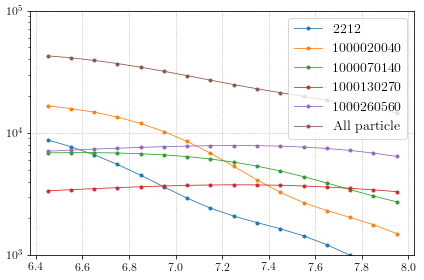

In [43]:
fig, ax = plt.subplots()
for key in model_flux_df.columns:
    ax.plot(np.log10(model_flux_df.index), model_flux_df.index**2.7*model_flux_df[key], label=key)
ax.plot(np.log10(model_flux_df.index), model_flux_df.index**2.7*model_flux_df.sum(axis=1), label='All particle')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(1e3, 1e5)
ax.grid()
ax.legend()
plt.show()

In [44]:
model_flux_df.sum(axis=1)

2.818383e+06    1.641346e-13
3.548134e+06    8.483512e-14
4.466836e+06    4.339894e-14
5.623413e+06    2.197001e-14
7.079458e+06    1.101287e-14
8.912509e+06    5.475336e-15
1.122018e+07    2.707370e-15
1.412538e+07    1.336061e-15
1.778279e+07    6.603585e-16
2.238721e+07    3.277380e-16
2.818383e+07    1.634461e-16
3.548134e+07    8.178036e-17
4.466836e+07    4.092131e-17
5.623413e+07    2.040978e-17
7.079458e+07    1.012960e-17
8.912509e+07    5.005529e-18
dtype: float64

In [68]:
simlist = np.unique(df_sim['sim'])
for i, sim in enumerate(simlist):
    gcd_file, sim_files = comp.simfunctions.get_level3_sim_files(sim)
    num_files = len(sim_files)
    if i == 0:
        generator = num_files*from_simprod(int(sim))
    else:
        generator += num_files*from_simprod(int(sim))

In [69]:
priors_list = ['h3a', 'h4a', 'antih3a', 'Hoerandel5', 'antiHoerandel5']
# priors_list = ['h3a', 'h4a', 'antih3a', 'Hoerandel5', 'antiHoerandel5', 'uniform', 'alllight', 'allheavy']
model_ptypes = {}
model_ptypes['h3a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['h4a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['Hoerandel5'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}

In [70]:
priors = defaultdict(list)
for flux, name in zip([GaisserH3a(), GaisserH3a(), GaisserH4a(), Hoerandel5(), Hoerandel5()],
                      ['h3a', 'antih3a', 'h4a', 'Hoerandel5', 'antiHoerandel5']):
    priors_raw = defaultdict(list)
    for energy_mid in energybins.energy_midpoints:
        energy = [energy_mid]*5
        ptype = [2212, 1000020040, 1000070140, 1000130270, 1000260560]
        weights = flux(energy, ptype)
#         light_prior = weights[:2].sum()/weights.sum()
#         heavy_prior = weights[2:].sum()/weights.sum()
        light_prior = weights[:2].sum()
        heavy_prior = weights[2:].sum()
        if 'anti' in name:
            priors_raw['light'].append(heavy_prior)
            priors_raw['heavy'].append(light_prior)
        else:
            priors_raw['light'].append(light_prior)
            priors_raw['heavy'].append(heavy_prior)
        priors[name].extend([light_prior, heavy_prior])
    unfolding_df['{}_flux_light'.format(name)] = priors_raw['light']
    unfolding_df['{}_flux_heavy'.format(name)] = priors_raw['heavy']
    
# unfolding_df['uniform_flux_light'] = [0.5]*len(priors_raw['light'])
# unfolding_df['uniform_flux_heavy'] = [0.5]*len(priors_raw['heavy'])

# unfolding_df['alllight_flux_light'] = [0.9]*len(priors_raw['light'])
# unfolding_df['alllight_flux_heavy'] = [0.1]*len(priors_raw['heavy'])

# unfolding_df['allheavy_flux_light'] = [0.1]*len(priors_raw['light'])
# unfolding_df['allheavy_flux_heavy'] = [0.9]*len(priors_raw['heavy'])

In [71]:
unfolding_df

,counts_heavy,counts_heavy_err,counts_light,counts_light_err,counts_total,counts_total_err,h3a_flux_light,h3a_flux_heavy,antih3a_flux_light,antih3a_flux_heavy,h4a_flux_light,h4a_flux_heavy,Hoerandel5_flux_light,Hoerandel5_flux_heavy,antiHoerandel5_flux_light,antiHoerandel5_flux_heavy
log_energy_bin_idx,,,,,,,,,,,,,,,,
0,665828,815.982843,1352390,1162.923041,2018218,1420.639997,1.366151e-12,7.458795e-13,7.458795e-13,1.366151e-12,1.393128e-12,7.355517e-13,9.348110e-13,7.382674e-13,7.382674e-13,9.348110e-13
1,533109,730.143137,1064113,1031.558530,1597222,1263.812486,7.187420e-13,4.082709e-13,4.082709e-13,7.187420e-13,7.333020e-13,4.023280e-13,4.929408e-13,4.021078e-13,4.021078e-13,4.929408e-13
2,447248,668.766028,742612,861.749384,1189860,1090.807041,3.743101e-13,2.232925e-13,2.232925e-13,3.743101e-13,3.821589e-13,2.198728e-13,2.569923e-13,2.189871e-13,2.189871e-13,2.569923e-13
3,332069,576.254284,521807,722.362098,853876,924.054111,1.925426e-13,1.219901e-13,1.219901e-13,1.925426e-13,1.967681e-13,1.200223e-13,1.318928e-13,1.192305e-13,1.192305e-13,1.318928e-13
4,225416,474.779949,368332,606.903617,593748,770.550453,9.758423e-14,6.655038e-14,6.655038e-14,9.758423e-14,9.985590e-14,6.541805e-14,6.629980e-14,6.488824e-14,6.488824e-14,6.629980e-14
5,143558,378.890485,258678,508.603972,402236,634.220782,4.859649e-14,3.623863e-14,3.623863e-14,4.859649e-14,4.981589e-14,3.558706e-14,3.247099e-14,3.528813e-14,3.528813e-14,3.247099e-14
6,98431,313.737151,165036,406.246231,263467,513.290366,2.371232e-14,1.968663e-14,1.968663e-14,2.371232e-14,2.436579e-14,1.931170e-14,1.541614e-14,1.916844e-14,1.916844e-14,1.541614e-14
7,69492,263.613353,99282,315.090463,168774,410.821129,1.130669e-14,1.066331e-14,1.066331e-14,1.130669e-14,1.165624e-14,1.044758e-14,7.062637e-15,1.039346e-14,1.039346e-14,7.062637e-15
8,40949,202.358593,64708,254.377672,105657,325.049227,5.257994e-15,5.754872e-15,5.754872e-15,5.257994e-15,5.444601e-15,5.630737e-15,3.109625e-15,5.620064e-15,5.620064e-15,3.109625e-15


In [72]:
unfolding_df_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'unfolding-dataframe.csv')
comp.check_output_dir(unfolding_df_outfile)
unfolding_df.to_csv(unfolding_df_outfile)

## Formatting for PyUnfold use

In [73]:
formatted_df = pd.DataFrame()

In [74]:
counts_formatted = []
priors_formatted = defaultdict(list)
for index, row in unfolding_df.iterrows():
    counts_formatted.extend([row['counts_light'], row['counts_heavy']])
    for priors_name in priors_list:
        priors_formatted[priors_name].extend([row[priors_name+'_flux_light'], row[priors_name+'_flux_heavy']])
        
formatted_df['counts'] = counts_formatted
formatted_df['counts_err'] = np.sqrt(counts_formatted)

formatted_df['efficiencies'] = efficiencies
formatted_df['efficiencies_err'] = efficiencies_err


for key, value in priors_formatted.iteritems():
    formatted_df[key+'_flux'] = value
    formatted_df[key+'_priors'] = formatted_df[key+'_flux'] / formatted_df[key+'_flux'].sum()

formatted_df.index.rename('log_energy_bin_idx', inplace=True)

In [75]:
formatted_df

,counts,counts_err,efficiencies,efficiencies_err,Hoerandel5_flux,Hoerandel5_priors,h3a_flux,h3a_priors,antiHoerandel5_flux,antiHoerandel5_priors,h4a_flux,h4a_priors,antih3a_flux,antih3a_priors
log_energy_bin_idx,,,,,,,,,,,,,,
0,1352390.0,1162.923041,0.002494,0.000036,9.348110e-13,2.623266e-01,1.366151e-12,3.044440e-01,7.382674e-13,2.071725e-01,1.393128e-12,3.081091e-01,7.458795e-13,1.662178e-01
1,665828.0,815.982843,0.001980,0.000033,7.382674e-13,2.071725e-01,7.458795e-13,1.662178e-01,9.348110e-13,2.623266e-01,7.355517e-13,1.626772e-01,1.366151e-12,3.044440e-01
2,1064113.0,1031.558530,0.003043,0.000036,4.929408e-13,1.383290e-01,7.187420e-13,1.601703e-01,4.021078e-13,1.128395e-01,7.333020e-13,1.621796e-01,4.082709e-13,9.098237e-02
3,533109.0,730.143137,0.002737,0.000038,4.021078e-13,1.128395e-01,4.082709e-13,9.098237e-02,4.929408e-13,1.383290e-01,4.023280e-13,8.898027e-02,7.187420e-13,1.601703e-01
4,742612.0,861.749384,0.003383,0.000028,2.569923e-13,7.211716e-02,3.743101e-13,8.341427e-02,2.189871e-13,6.145214e-02,3.821589e-13,8.451960e-02,2.232925e-13,4.976030e-02
5,447248.0,668.766028,0.003190,0.000029,2.189871e-13,6.145214e-02,2.232925e-13,4.976030e-02,2.569923e-13,7.211716e-02,2.198728e-13,4.862784e-02,3.743101e-13,8.341427e-02
6,521807.0,722.362098,0.003571,0.000027,1.318928e-13,3.701174e-02,1.925426e-13,4.290774e-02,1.192305e-13,3.345845e-02,1.967681e-13,4.351792e-02,1.219901e-13,2.718525e-02
7,332069.0,576.254284,0.003417,0.000028,1.192305e-13,3.345845e-02,1.219901e-13,2.718525e-02,1.318928e-13,3.701174e-02,1.200223e-13,2.654454e-02,1.925426e-13,4.290774e-02
8,368332.0,606.903617,0.003672,0.000030,6.629980e-14,1.860504e-02,9.758423e-14,2.174645e-02,6.488824e-14,1.820893e-02,9.985590e-14,2.208448e-02,6.655038e-14,1.483062e-02


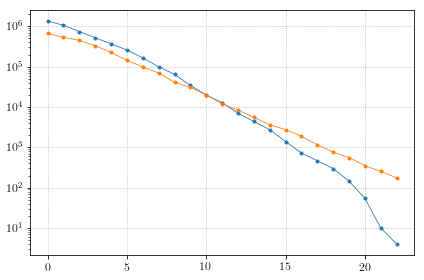

In [76]:
plt.plot(formatted_df['counts'][::2].values)
plt.plot(formatted_df['counts'][1::2].values)
plt.yscale("log", nonposy='clip')
plt.grid()
plt.show()

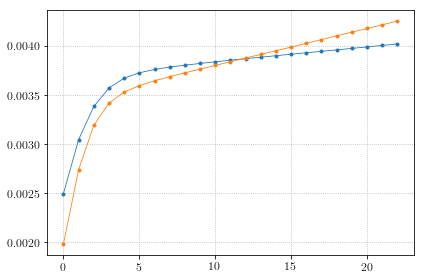

In [77]:
plt.plot(formatted_df['efficiencies'][::2].values)
plt.plot(formatted_df['efficiencies'][1::2].values)
plt.grid()
plt.show()

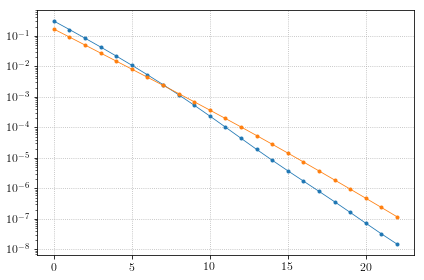

In [78]:
plt.plot(formatted_df['h3a_priors'][::2].values)
plt.plot(formatted_df['h3a_priors'][1::2].values)
plt.yscale("log", nonposy='clip')
plt.grid()
plt.show()

Save formatted DataFrame to disk

In [79]:
formatted_df_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding',
                                    'unfolding-dataframe-PyUnfold-formatted.csv')
comp.check_output_dir(formatted_df_outfile)
formatted_df.to_csv(formatted_df_outfile)

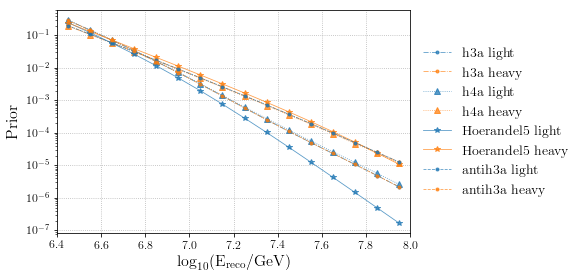

In [77]:
# model_to_ls = {'h3a': '-.', 'h4a': ':', 'Hoerandel5': '-', 'antih3a': '--'}
# model_to_marker = {'h3a': '.', 'h4a': '^', 'Hoerandel5': '*', 'antih3a': '.'}

# fig, ax = plt.subplots()
# for model in ['h3a', 'h4a', 'Hoerandel5', 'antih3a']:
#     key = '{}_priors'.format(model)
#     light_priors = formatted_df[key][::2]
#     heavy_priors = formatted_df[key][1::2]
#     ax.plot(energybins.log_energy_midpoints, light_priors,
#             color=color_dict['light'], ls=model_to_ls[model], marker=model_to_marker[model],
#             label='{} light'.format(model), alpha=0.75)
#     ax.plot(energybins.log_energy_midpoints, heavy_priors,
#             color=color_dict['heavy'], ls=model_to_ls[model], marker=model_to_marker[model],
#             label='{} heavy'.format(model), alpha=0.75)

# ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
# ax.set_ylabel('Prior')
# ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
# # ax.set_ylim([0, 1])
# ax.set_yscale("log", nonposy='clip')
# ax.grid()
# leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#                  frameon=False, fancybox=False, numpoints=1)
# priors_outfile = os.path.join(comp.paths.figures_dir, 'unfolding/iter-bayesian', 'priors.png')
# comp.check_output_dir(priors_outfile)
# plt.savefig(priors_outfile)
# plt.show()

In [130]:
woo = pd.read_csv(formatted_df_outfile, index_col='log_energy_bin_idx')

In [131]:
woo

,counts,counts_err,Hoerandel5_flux,Hoerandel5_priors,h3a_flux,h3a_priors,antiHoerandel5_flux,antiHoerandel5_priors,h4a_flux,h4a_priors,antih3a_flux,antih3a_priors
log_energy_bin_idx,,,,,,,,,,,,
0,360613.0,600.510616,6.629980e-14,2.471037e-01,9.758423e-14,0.290274,6.488824e-14,2.418428e-01,9.985590e-14,0.295078,6.655038e-14,0.197960
1,233037.0,482.739060,6.488824e-14,2.418428e-01,6.655038e-14,0.197960,6.629980e-14,2.471037e-01,6.541805e-14,0.193313,9.758423e-14,0.290274
2,256442.0,506.401027,3.247099e-14,1.210215e-01,4.859649e-14,0.144555,3.528813e-14,1.315212e-01,4.981589e-14,0.147208,3.623863e-14,0.107795
3,145728.0,381.743369,3.528813e-14,1.315212e-01,3.623863e-14,0.107795,3.247099e-14,1.210215e-01,3.558706e-14,0.105161,4.859649e-14,0.144555
4,164393.0,405.454066,1.541614e-14,5.745698e-02,2.371232e-14,0.070535,1.916844e-14,7.144202e-02,2.436579e-14,0.072002,1.968663e-14,0.058560
5,99038.0,314.703035,1.916844e-14,7.144202e-02,1.968663e-14,0.058560,1.541614e-14,5.745698e-02,1.931170e-14,0.057067,2.371232e-14,0.070535
6,102273.0,319.801501,7.062637e-15,2.632291e-02,1.130669e-14,0.033633,1.039346e-14,3.873710e-02,1.165624e-14,0.034445,1.066331e-14,0.031719
7,66484.0,257.844915,1.039346e-14,3.873710e-02,1.066331e-14,0.031719,7.062637e-15,2.632291e-02,1.044758e-14,0.030873,1.130669e-14,0.033633
8,64793.0,254.544692,3.109625e-15,1.158978e-02,5.257994e-15,0.015640,5.620064e-15,2.094635e-02,5.444601e-15,0.016089,5.754872e-15,0.017118


In [116]:
df = pd.read_csv(formatted_df_outfile, index_col='log_energy_bin_idx')

In [117]:
df

,counts,allheavy_priors,h3a_priors,h4a_priors,alllight_priors,Hoerandel5_priors,uniform_priors,antih3a_priors,antiHoerandel5_priors
log_energy_bin_idx,,,,,,,,,
0,360613.0,0.1,0.594538,0.604184,0.9,0.505380,0.5,0.405462,0.494620
1,233037.0,0.9,0.405462,0.395816,0.1,0.494620,0.5,0.594538,0.505380
2,256442.0,0.1,0.572835,0.583304,0.9,0.479212,0.5,0.427165,0.520788
3,145728.0,0.9,0.427165,0.416696,0.1,0.520788,0.5,0.572835,0.479212
4,164393.0,0.1,0.546380,0.557857,0.9,0.445752,0.5,0.453620,0.554248
5,99038.0,0.9,0.453620,0.442143,0.1,0.554248,0.5,0.546380,0.445752
6,102273.0,0.1,0.514642,0.527341,0.9,0.404594,0.5,0.485358,0.595406
7,66484.0,0.9,0.485358,0.472659,0.1,0.595406,0.5,0.514642,0.404594
8,64793.0,0.1,0.477441,0.491597,0.9,0.356213,0.5,0.522559,0.643787
